In [76]:
import os

import pandas as pd
import geopandas as gpd

import shapely
from shapely.geometry import LineString

from gtfs_data import GTFSData

data_dir = r'Q:\SACSIM23\Network\TransitNetwork\GTFS\Auburn'
os.chdir(data_dir)

gtfs = GTFSData(gtfs_dir=data_dir, data_year=2020)


# update strings to date time format
gtfs.df_stoptimes[gtfs.f_depart_time] = pd.to_datetime(gtfs.df_stoptimes[gtfs.f_depart_time])
gtfs.df_stoptimes[gtfs.f_arrive_time] = pd.to_datetime(gtfs.df_stoptimes[gtfs.f_arrive_time])

# IMPORTANTLY, probably need to only include stops with arrival and departure times
gtfs.df_stoptimes = gtfs.df_stoptimes.loc[pd.notnull(gtfs.df_stoptimes['arrival_time'])]


In [87]:
gtfs.df_stoptimes.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,start_service_area_id,end_service_area_id,start_service_area_radius,end_service_area_radius,continuous_pickup,continuous_drop_off,pickup_area_id,drop_off_area_id,pickup_service_area_radius,drop_off_service_area_radius
0,t_1063565_b_25331_tn_1,2023-01-12 09:00:00,2023-01-12 09:00:00,2583249,1,Raley's,0,0,0.000000,1,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN
5,t_1063565_b_25331_tn_1,2023-01-12 09:11:00,2023-01-12 09:11:00,2583284,6,Raley's,0,0,6000.069524,1,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN
14,t_1063565_b_25331_tn_1,2023-01-12 09:24:00,2023-01-12 09:24:00,2583271,15,Nevada Station,0,0,11359.795408,1,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN
20,t_1063565_b_25331_tn_1,2023-01-12 09:35:00,2023-01-12 09:35:00,2583253,21,Nevada Station,0,0,16948.602711,1,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN
23,t_1063565_b_25331_tn_1,2023-01-12 09:40:00,2023-01-12 09:40:00,2583251,24,Nevada Station,0,0,18250.915465,1,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN


In [97]:
# for a single trip, get geometry of its trip line shape and geom of stops made on that trip

test_trip_id = 't_1063569_b_25331_tn_1'
df_test_trip = gtfs.df_trips.loc[gtfs.df_trips['trip_id'] == test_trip_id]
gdf_test_tripshp = df_test_trip.join(gtfs.gdf_lineshps, on='shape_id')
gdf_test_tripshp = gpd.GeoDataFrame(gdf_test_tripshp, geometry='geometry') # need this to make geo df instead of regular df

gdf_test_stops = df_test_trip.merge(gtfs.df_stoptimes, on='trip_id') \
                .merge(gtfs.gdf_stops, on='stop_id') \
                [['trip_id', 'stop_id', 'stop_sequence', 'geometry']].drop_duplicates() \
                .sort_values(by='stop_sequence')
gdf_test_stops = gpd.GeoDataFrame(gdf_test_stops, geometry='geometry') # need this to make geo df instead of regular df
# gdf_test_stops = gdf_test_stops.merge(gtfs.df_stoptimes, on=['trip_id', 'stop_id', 'stop_sequence'])


In [98]:
gdf_test_stops.head()

,trip_id,stop_id,stop_sequence,geometry
0,t_1063569_b_25331_tn_1,2583249,1,POINT (6822690.756 2092122.871)
1,t_1063569_b_25331_tn_1,2583284,6,POINT (6825924.682 2090461.426)
3,t_1063569_b_25331_tn_1,2583271,15,POINT (6830636.338 2099567.489)
4,t_1063569_b_25331_tn_1,2583253,21,POINT (6825552.179 2096480.515)
5,t_1063569_b_25331_tn_1,2583251,24,POINT (6825220.922 2093024.088)


In [99]:

first_pair

,trip_id,stop_id,stop_sequence,geometry
0,t_1063569_b_25331_tn_1,2583249,1,POINT (6822690.756 2092122.871)
1,t_1063569_b_25331_tn_1,2583284,6,POINT (6825924.682 2090461.426)


In [110]:
# split trip's line by trip's stop points

# test pair of stop points
first_pair = gdf_test_stops.loc[gdf_test_stops.index < 2]

# union all geometries
line = gdf_test_tripshp.geometry[0]
coords = first_pair.geometry.unary_union

# snap and split coords on line
# returns GeometryCollection
split_line = shapely.ops.split(line, shapely.ops.snap(coords, line, tolerance=50.0))

# transform Geometry Collection to GeoDataFrame
segments = [feature for feature in split_line]

gdf_segments = gpd.GeoDataFrame(
list(range(len(segments))), geometry=segments)
gdf_segments.columns = ['index', 'geometry']

# gdf_segments.loc[gdf_segments.index == 2].plot(figsize=(10, 10), alpha=0.5, edgecolor='k')


In [113]:
# get the line segment that corresponse to the portion between the two stops, not before or after them
gdf_segments = gdf_segments.loc[gdf_segments.index == 1]

# add trip id to segment
gdf_segments['trip_id'] = test_trip_id

# select the 2 stops closest to the segment
first_pair['dist_to_line'] = first_pair.distance(gdf_segments)
first_pair = first_pair.sort_values(by=['dist_to_line'])[:2]
first_pair = first_pair.sort_values(by=['stop_sequence'])

# start dict of segment data
seg_data = {}

# join segment table to stop time table
jn = first_pair.merge(gtfs.df_stoptimes, on=['trip_id', 'stop_id', 'stop_sequence'], suffixes=('', 'y'))
jn.head()
stop1_data = jn.iloc[0]
stop2_data = jn.iloc[1]

seg_data['begin_stop'] = stop1_data['stop_id']
seg_data['end_stop'] = stop2_data['stop_id']
seg_data['seg_len_mi'] = gdf_segments.length.mean() / 5280
seg_data['seg_start_time'] = stop1_data['departure_time']
seg_data['seg_end_time'] = stop2_data['arrival_time']
seg_data['duration_mins'] = (seg_data['seg_end_time'] - seg_data['seg_start_time']).seconds / 60
seg_data['speed_mph'] = seg_data['seg_len_mi'] / (seg_data['duration_mins'] / 60)


seg_data

C:\Users\dconly\AppData\Local\ESRI\conda\envs\arcgispro-jul052022\lib\site-packages\geopandas\base.py:32: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
<ipython-input-113-f963829d58e1>:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2226
Right CRS: None

  first_pair['dist_to_line'] = first_pair.distance(gdf_segments)


{'begin_stop': 2583249,
 'end_stop': 2583284,
 'seg_len_mi': array([0.97841947]),
 'seg_start_time': Timestamp('2023-01-12 16:00:00'),
 'seg_end_time': Timestamp('2023-01-12 16:11:00'),
 'duration_mins': 11.0}

In [118]:
gdf_segments.length.mean()

5166.054776692899

<AxesSubplot:>

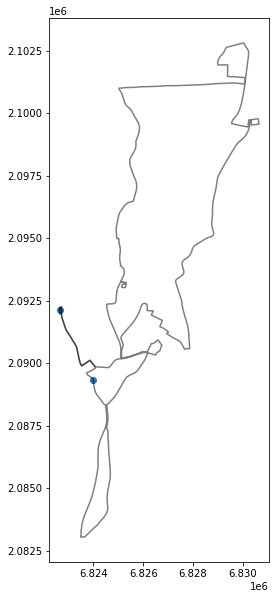

In [34]:
# ax = gdf_segments.loc[gdf_segments.index == 0].plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ax = gdf_segments.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
df_nearest_seg = gdf_test_stops.loc[gdf_test_stops['segtouch'] < 100]
first_pair.plot(ax=ax)